In [1]:
import matplotlib.pyplot as plt
import numpy as np
import numpy.typing as npt
from config import CONFIG, RL_CONFIG, SWING_CONFIG
from environment.grid import Grid
from environment.swing.solver import swing_solver
from environment.trajectory import is_stable

CONFIG.from_yaml("config.yaml")

In [2]:
def find_steady_state(
    grid: Grid, rng: np.random.Generator
) -> list[npt.NDArray[np.float32]]:
    """Find random initial state of given grid.
    Args
        grid: In which grid to find initial state
        rng: used for initializing random phase
    Return
        phase: [N, ] phase of each node in (-pi, pi]
        dphase: [N, ] dphase (angular frequency) of each node
    """

    # Initial random state
    # phase = rng.uniform(-np.pi, np.pi, grid.num_nodes).astype(np.float32)
    phase = np.zeros(grid.num_nodes, dtype=np.float32)
    dphase = np.zeros_like(phase)

    dphases = []

    # Run swing equation until reaching steady time
    time = 0.0
    solver = swing_solver(grid.weighted_adjacency_matrix, grid.params)
    while time < RL_CONFIG.steady_time:
        time += SWING_CONFIG._dt
        phase, dphase = solver(phase=phase, dphase=dphase)
        dphases.append(dphase)
        if is_stable(dphase):
            break

    return dphases

grid = Grid(rng=0)


Node 0 - Type: GENERATOR, max: 6, active: 4
Node 1 - Type: CONSUMER, max: 10, active: 6
Node 2 - Type: CONSUMER, max: 10, active: 6
Node 3 - Type: CONTROLLABLE_CONSUMER, max: 10, active: 6
Node 4 - Type: GENERATOR, max: 11, active: 6
Node 5 - Type: RENEWABLE, max: 3, active: 2
Node 6 - Type: RENEWABLE, max: 6, active: 3
Node 7 - Type: CONSUMER, max: 10, active: 6
Node 8 - Type: GENERATOR, max: 5, active: 3
Node 9 - Type: GENERATOR, max: 11, active: 6
Steady at t=17.5, max_dphase=9.991595288738608e-05


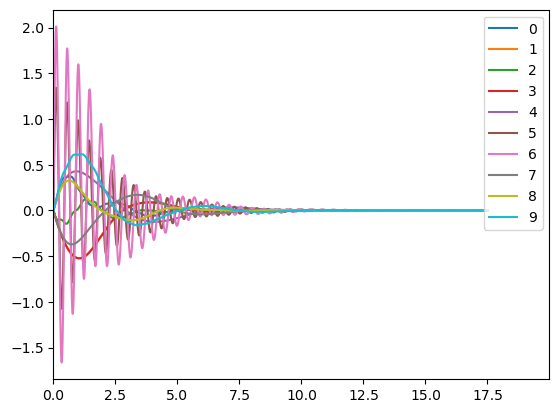

In [3]:
# grid.reset_nodes()
# grid.reset_node_types()
# grid.reset_graph()

print(grid)

dphases = np.stack(find_steady_state(grid, grid.rng))
time = np.arange(0.0, RL_CONFIG.steady_time, SWING_CONFIG._dt)
print(
    f"Steady at t={len(dphases) * SWING_CONFIG._dt}, max_dphase={np.abs(dphases[-1]).max()}"
)

for i, dphase in enumerate(dphases.T):
    plt.plot(time[: len(dphase)], dphase, label=i)
plt.legend()
plt.xlim(0, time[-1])
plt.show()